In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
import numpy as np

import skimage.io
import sklearn.metrics
import sklearn.svm
import datetime
import h5py
import sys
import os
import gc

sys.path.append('../Data_Preprocessing/')
from Preprocess_Utilities import *
from Visualization import *

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path_raw_dir   = "../Data/090085/"
path_raw_image = "../Data/090085/090085_20170531.h5"

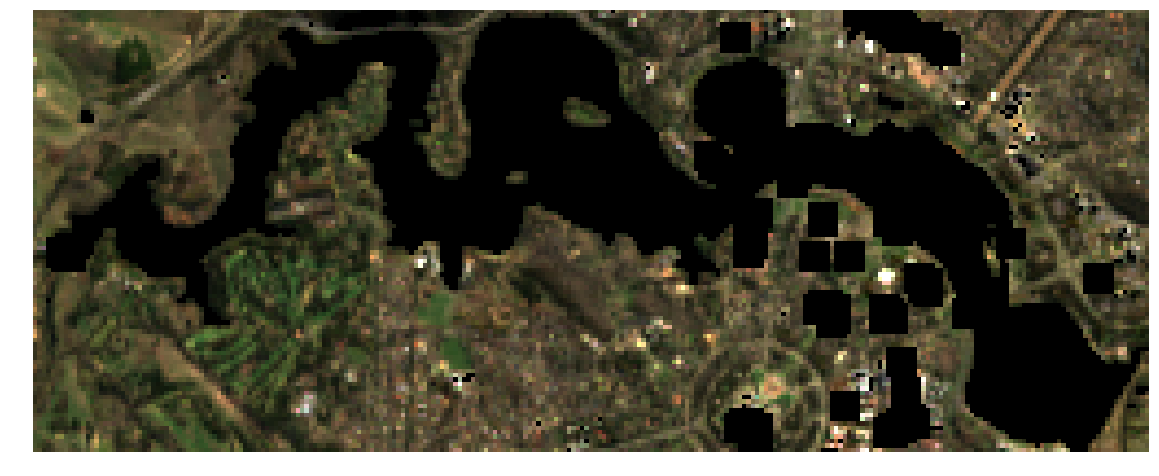

In [3]:
h5f = h5py.File(path_raw_image)
raw_image = np.array(h5f['scene'])
h5f.close()
show_raw_image(raw_image, x=1139, y=3000, x_size=101, y_size=255)

In [4]:
valid_date_list = ['20131011', '20131230', 
                   '20140115', '20140131', '20140216', '20140827', '20141030', '20141217',
                   '20150102', '20150307', '20150408', '20150915', '20151001', '20151205', 
                   '20160206', '20160325', '20160410', '20161104', '20161120', '20161206', '20161222',
                   '20170208']

In [5]:
date_volum_dict = {}
x = 1139
y = 3000
x_size = 101
y_size = 255
cal_volume = lambda h5f: (np.array(h5f['scene'][0,x:x+x_size, y:y+y_size]) == -9999).sum()
for filename in os.listdir(path_raw_dir):
    if '090085_20' not in filename: continue
    cur_date = filename.split('_')[1].split('.')[0]
    if cur_date not in valid_date_list: continue

    h5f = h5py.File(path_raw_dir+filename)
    cur_volume = cal_volume(h5f)
    h5f.close()
    gc.collect()
    
    
    cur_date = datetime.date(int(cur_date[:4]), int(cur_date[4:6]), int(cur_date[6:]))
    
    date_volum_dict[cur_date] = cur_volume
date_list = sorted(date_volum_dict.keys(), key=lambda r: r)
print(len(date_list))
date_list

21


[datetime.date(2013, 10, 11),
 datetime.date(2013, 12, 30),
 datetime.date(2014, 1, 15),
 datetime.date(2014, 1, 31),
 datetime.date(2014, 2, 16),
 datetime.date(2014, 8, 27),
 datetime.date(2014, 10, 30),
 datetime.date(2014, 12, 17),
 datetime.date(2015, 1, 2),
 datetime.date(2015, 3, 7),
 datetime.date(2015, 4, 8),
 datetime.date(2015, 9, 15),
 datetime.date(2015, 10, 1),
 datetime.date(2016, 2, 6),
 datetime.date(2016, 3, 25),
 datetime.date(2016, 4, 10),
 datetime.date(2016, 11, 4),
 datetime.date(2016, 11, 20),
 datetime.date(2016, 12, 6),
 datetime.date(2016, 12, 22),
 datetime.date(2017, 2, 8)]

In [30]:
day_list    = []
volume_list = []
min_date = min(date_list)
for date in date_list:
    day_list.append((date-min_date).days)
    volume_list.append(date_volum_dict[date])
    
volume_list = np.array(volume_list)

In [31]:
truth_val  = np.array([29131, 33242, 33723, 34073, 33674])
truth_date = [datetime.date(2013, 6, 30),
              datetime.date(2014, 6, 30),
              datetime.date(2015, 6, 30),
              datetime.date(2016, 6, 30),
              datetime.date(2017, 6, 30)]
truth_day  = [(x-min_date).days for x in truth_date]
# 30 June 2013: 29131 ML
# 30 June 2014: 33242 ML
# 30 June 2015: 33723 ML
# 30 June 2016: 34073 ML
# 30 June 2017: 33674 ML


[0.45501285 0.68380463 0.56812339 0.6066838  0.67609254 1.
 0.         0.37789203 0.36503856 0.4781491  0.73007712 0.94344473
 0.70951157 0.35989717 0.41131105 0.40102828 0.49357326 0.42930591
 0.61439589 0.6066838  0.52699229]
[29131 33242 33723 34073 33674]


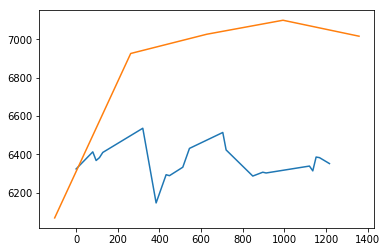

6536

In [41]:
# plt.scatter(day_list, volume_list, marker='.', label='pixel')
# plt.scatter(truth_day, true_val,  marker='.', label='ML')
plt.plot(day_list, volume_list, label='pixel')
plt.plot(truth_day, truth_val/4.8, label='ML')
print(norm_volume_list)
print(truth_val)
plt.show()
max(volume_list) # <1:25755, <0.7/0.6:14838, <0.5:12093, <0.4:9977, <0.3:7704, <0.2

score: 0.5123224090518121


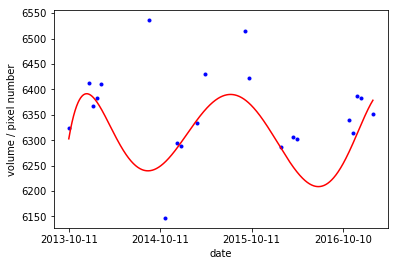

In [133]:
def get_feature_list(lst):
    feaatures = []
    for cur_idx in range(len(lst)):
        cur_feature = []
        cur_x = lst[cur_idx]
        
        if cur_idx == 0:
            last_x = cur_x
            next_x = lst[cur_idx+1]
            
        elif cur_idx == len(lst)-1:
            last_x = lst[cur_idx-1]
            next_x = cur_x

        else:
            last_x = lst[cur_idx-1]
            next_x = lst[cur_idx+1]
            
        cur_feature.append((next_x - cur_x)**2)
        cur_feature.append((last_x - cur_x)**2)
        cur_feature.extend([cur_x,cur_x**2,cur_x**3,cur_x**4, cur_x**5, cur_x**6])
        
        feaatures.append(cur_feature)
    return np.array(feaatures)

train_x = get_feature_list(day_list)
train_y = np.array(volume_list).reshape(-1, 1)
# train_x = (train_x - train_x.mean(axis=0))/train_x.std(axis=0)
sklinear = sklearn.linear_model.LinearRegression(normalize=True)
sklinear.fit(train_x, train_y)
print('score:', sklinear.score(get_feature_list(day_list), np.array(volume_list).reshape(-1, 1)))

pred_vol = sklinear.predict(get_feature_list(np.arange(max(day_list))))

plt.scatter(day_list, volume_list, marker='.', color='b')
plt.plot(pred_vol, color='r')
plt.ylabel('volume / pixel number')
plt.xlabel('date')
xtick=[0,365,2*365, 3*365]
plt.xticks(xtick, [min_date+datetime.timedelta(days=x) for x in xtick])
plt.savefig('./Result/lake_size_in_T', bbox_inches='tight', transparent=True)
plt.show()

In [98]:
train_x.std(axis=0)

array([4.00216903e+02, 5.15246018e+05, 6.20632207e+08, 7.37090028e+11,
       8.71852576e+14])

In [88]:
train_x.shape

(21, 6)

2013-10-11


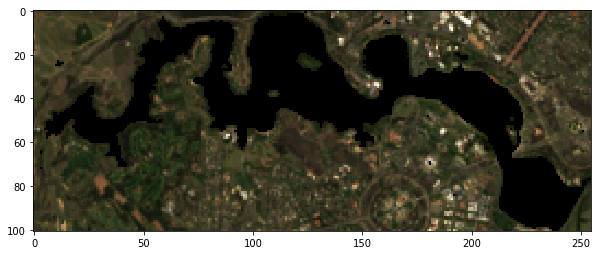

2013-12-30


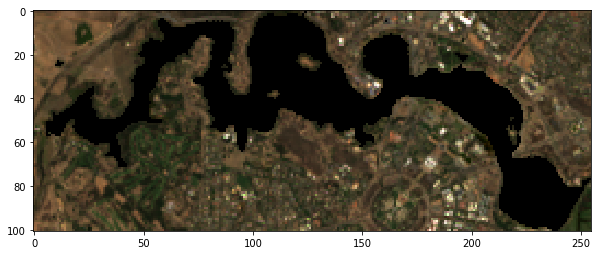

2014-01-15


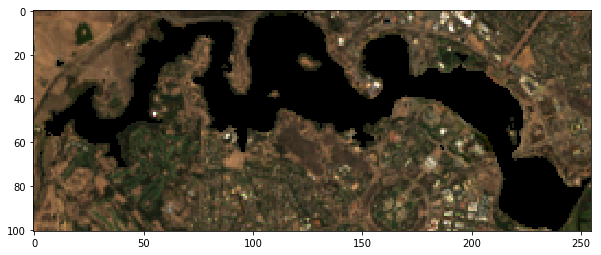

2014-01-31


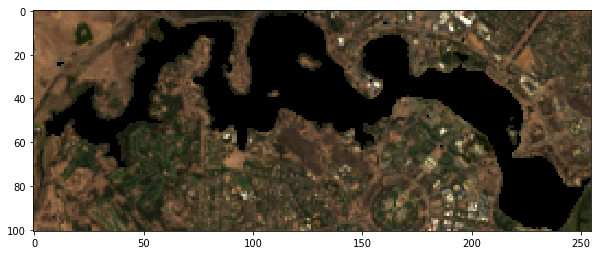

2014-02-16


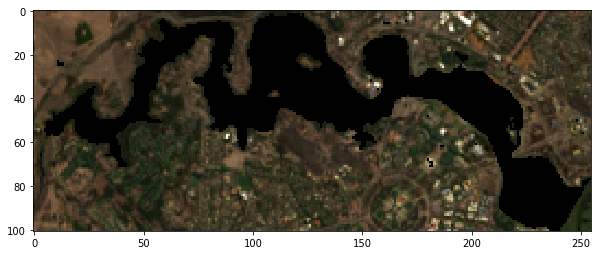

2014-08-27


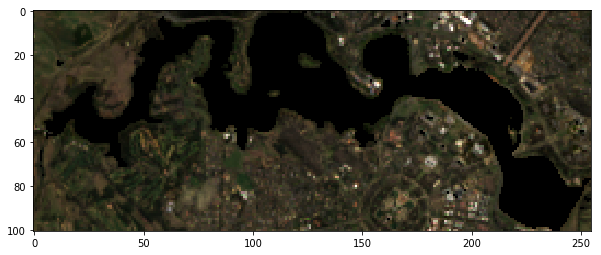

2014-10-30


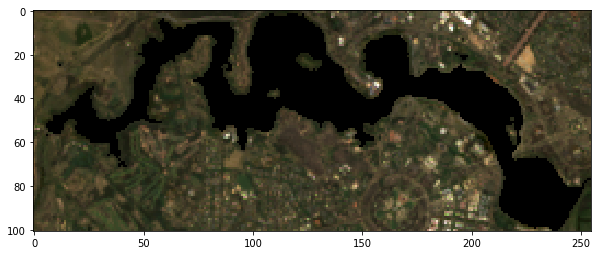

2014-12-17


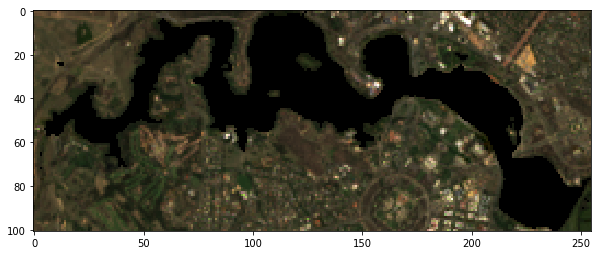

2015-01-02


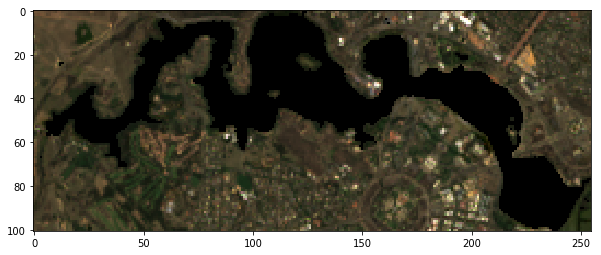

2015-03-07


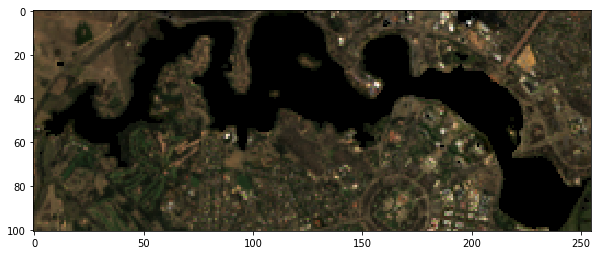

2015-04-08


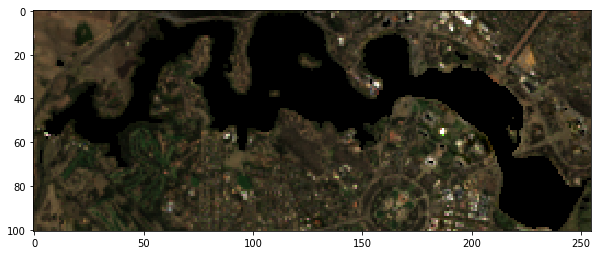

2015-09-15


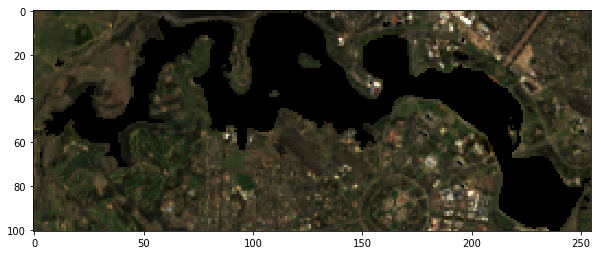

2015-10-01


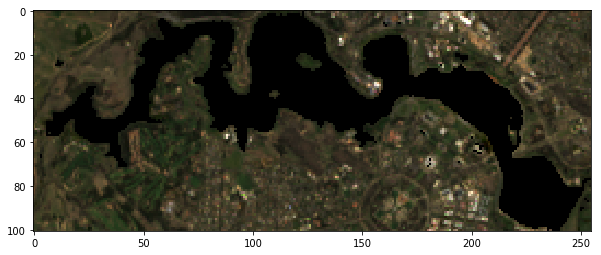

2016-02-06


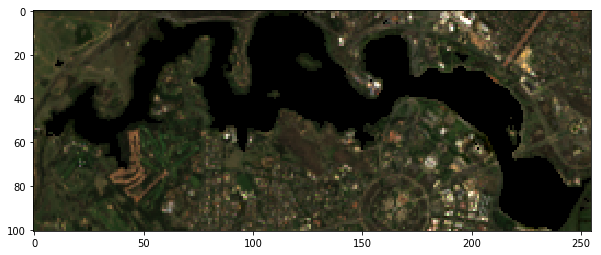

2016-03-25


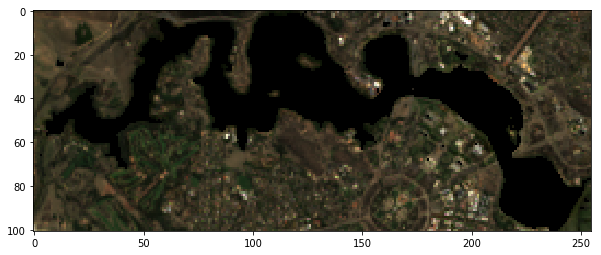

2016-04-10


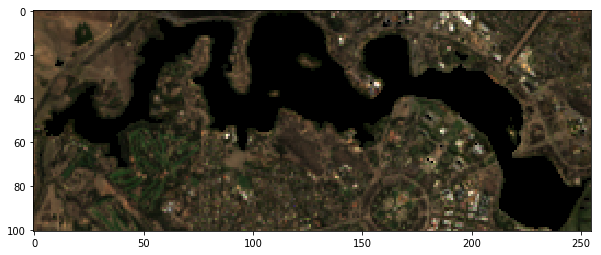

2016-11-04


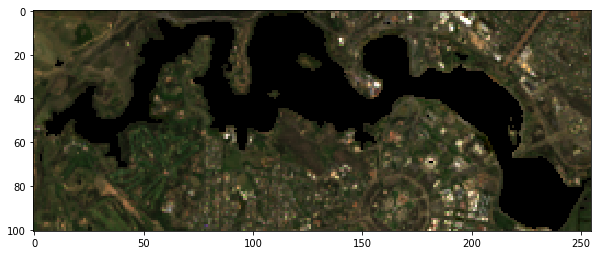

2016-11-20


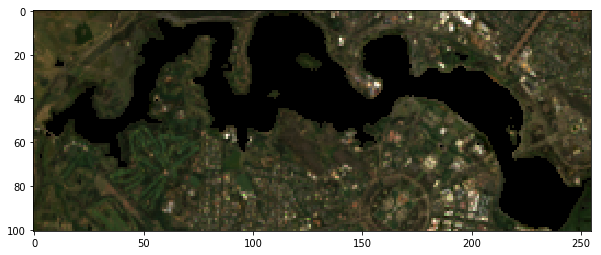

2016-12-06


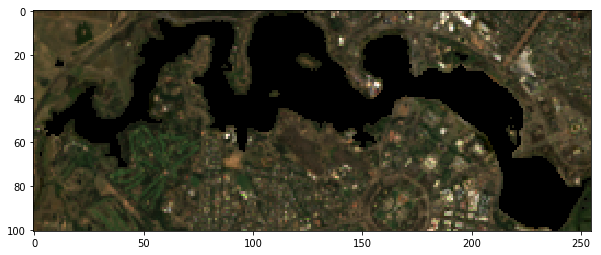

2016-12-22


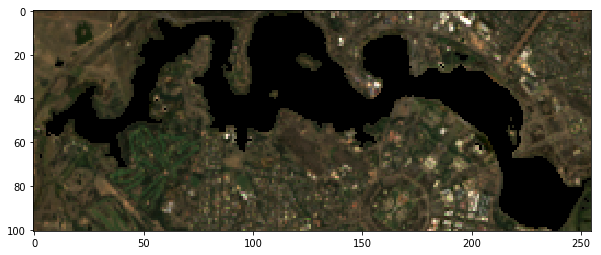

2017-02-08


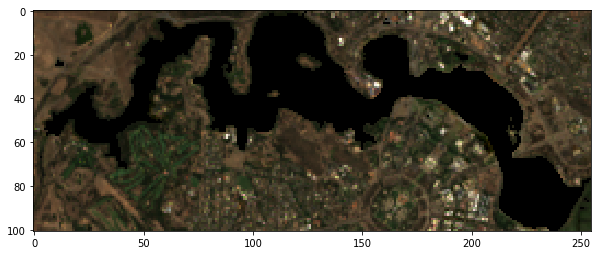

In [120]:
for k in date_list:
#     if date_volum_dict[k] == max(volume_list):
#         print(k)
    print(k)
    filename = '090085_' + str(k).replace('-', '')+'.h5'

    h5f = h5py.File(path_raw_dir+filename)
    patch = np.array(h5f['scene'][:,1139:1139+101, 3000:3000+255])
    h5f.close()
    show_raw_image(patch,size=-1, figsize=(10,10))

'090085_20160731.h5'

In [30]:
max(volume_list)

25755

In [ ]:
for name in name_list:
    raw_image = np.array(h5py.File(data_dir_path + name)['scene'])
    show_raw_image(raw_image, x=1120, y=3000, x_size=100, y_size=250, show_plot=False, 
                   save_path="./Result/"+name[7:15])